# purpose: 予測しなければいけないfloor(階数は不明だが)でつかえるパスはfloorのどれくらいの面積を占めるかをplotしたい。

In [1]:
import sys
sys.path.append("..")

import os
import json
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns

from PIL import Image, ImageOps
from skimage import io
from skimage.color import rgba2rgb, rgb2xyz
from tqdm import tqdm
from dataclasses import dataclass
from math import floor, ceil

from main import calibrate_magnetic_wifi_ibeacon_to_position
from main import extract_magnetic_strength
from io_f import read_data_file
from visualize_f import visualize_trajectory, visualize_heatmap
from main import calibrate_magnetic_wifi_ibeacon_to_position
from main import extract_magnetic_strength
from main import extract_wifi_rssi, extract_wifi_count
from processing import SUBMISSION_SITES, split_sample_sbm_to_dataframe, formatting_for_visualize_waypoint
from tqdm import tqdm
import os

import lightgbm as lgb

sns.set_theme()

%load_ext autoreload
%autoreload 2

Duplicate key in file PosixPath('/Users/takahashigenki/.matplotlib/stylelib/genki.mplstyle'), line 176 ('font.family         : IPAexGothic')


# data load

In [2]:
train_paths = glob.glob("../train/*/*/*.txt")

In [3]:
train_paths

['../train/5da138764db8ce0c98bcaa46/F4/5dabfad918410e00067e70ba.txt',
 '../train/5da138764db8ce0c98bcaa46/F4/5dac3de918410e00067e7244.txt',
 '../train/5da138764db8ce0c98bcaa46/F4/5dabfac518410e00067e70a6.txt',
 '../train/5da138764db8ce0c98bcaa46/F4/5dabfac218410e00067e70a2.txt',
 '../train/5da138764db8ce0c98bcaa46/F4/5dabfac418410e00067e70a4.txt',
 '../train/5da138764db8ce0c98bcaa46/F4/5dabfac3df065a00069bf058.txt',
 '../train/5da138764db8ce0c98bcaa46/F4/5dabfadbdf065a00069bf072.txt',
 '../train/5da138764db8ce0c98bcaa46/F4/5dabfadadf065a00069bf070.txt',
 '../train/5da138764db8ce0c98bcaa46/F4/5dabfadedf065a00069bf076.txt',
 '../train/5da138764db8ce0c98bcaa46/F4/5dabfadddf065a00069bf074.txt',
 '../train/5da138764db8ce0c98bcaa46/F4/5dac3ded18410e00067e7248.txt',
 '../train/5da138764db8ce0c98bcaa46/F4/5dabfad418410e00067e70b4.txt',
 '../train/5da138764db8ce0c98bcaa46/F4/5dabfad618410e00067e70b6.txt',
 '../train/5da138764db8ce0c98bcaa46/F4/5dabfad3df065a00069bf068.txt',
 '../train/5da138764

In [4]:
file = train_paths[0]
def scrape_building_name(path):
    with open(path) as f:
        data = f.readlines()
    for line in data:
        line_data = line.split()
        if not line_data:
            continue
        if (line_data[0] == '#') & (line_data[1].startswith('SiteID:')):
            site = line_data[1].split("SiteID:")[1]
            return site
    return false
scrape_building_name(file)

'5da138764db8ce0c98bcaa46'

# save submission site

In [5]:
set(split_sample_sbm_to_dataframe("../sample_submission.csv")["site"])

{'5a0546857ecc773753327266',
 '5c3c44b80379370013e0fd2b',
 '5d27075f03f801723c2e360f',
 '5d27096c03f801723c31e5e0',
 '5d27097f03f801723c320d97',
 '5d27099f03f801723c32511d',
 '5d2709a003f801723c3251bf',
 '5d2709b303f801723c327472',
 '5d2709bb03f801723c32852c',
 '5d2709c303f801723c3299ee',
 '5d2709d403f801723c32bd39',
 '5d2709e003f801723c32d896',
 '5da138274db8ce0c98bbd3d2',
 '5da1382d4db8ce0c98bbe92e',
 '5da138314db8ce0c98bbf3a0',
 '5da138364db8ce0c98bc00f1',
 '5da1383b4db8ce0c98bc11ab',
 '5da138754db8ce0c98bca82f',
 '5da138764db8ce0c98bcaa46',
 '5da1389e4db8ce0c98bd0547',
 '5da138b74db8ce0c98bd4774',
 '5da958dd46f8266d0737457b',
 '5dbc1d84c1eb61796cf7c010',
 '5dc8cea7659e181adb076a3f'}

これらのsiteの名前はprocessingに保存している。

In [6]:
def concatenate_formatting_waypoints(paths):
    rel = []
    for path in tqdm(paths):
        rel.extend(formatting_for_visualize_waypoint(path))
    return np.array(rel)

        

100%|██████████| 27/27 [00:01<00:00, 19.37it/s]



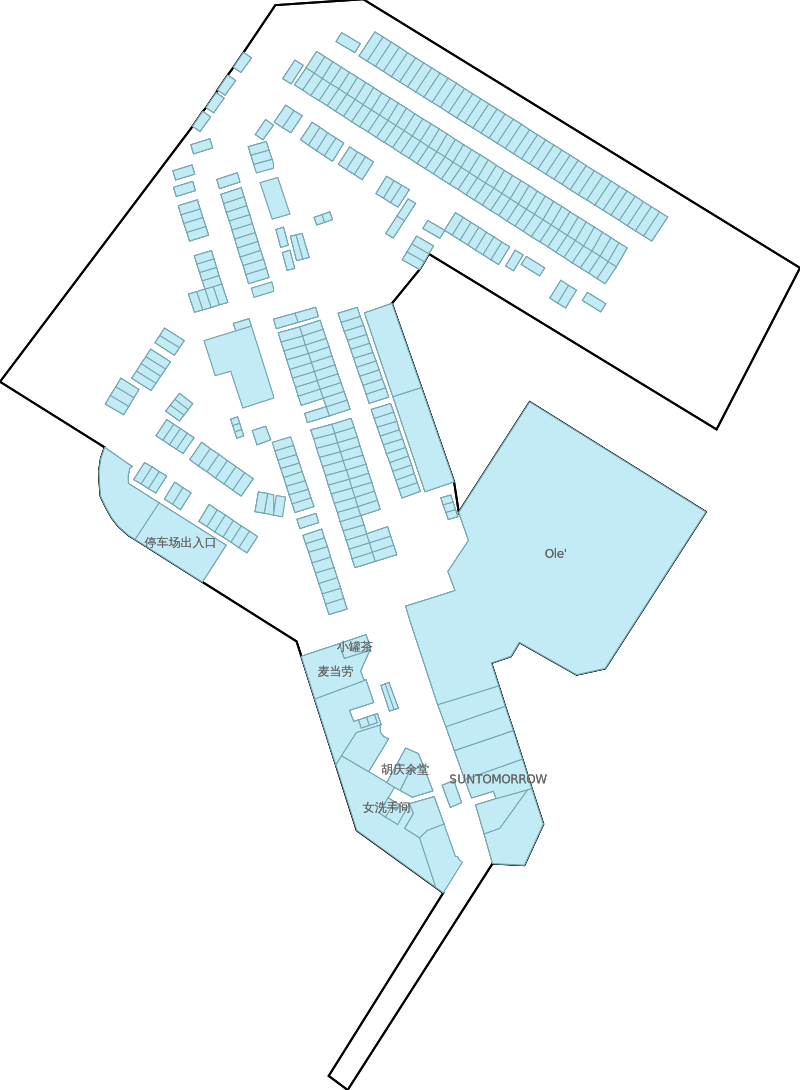

In [9]:
# select one site
sample = list(SUBMISSION_SITES)[1]
data = {}
for path in train_paths:
    path_data = path.split("/")    
    if path_data[2] == sample:
        if not path_data[3] in data.keys():
            data[f"{path_data[3]}"] = []
        data[f"{path_data[3]}"].append(path)

# result has structure devided by its floor
# display(data)


base = ".."
floor = "B2" # because we didnt create matching function of string floor name to the corresponding value;)
site = sample
pathway_paths = data[floor]


floor_plan_filename = f'{base}/metadata/{site}/{floor}/floor_image.png'

sample_pathway = concatenate_formatting_waypoints(pathway_paths)


# Prepare width_meter & height_meter
json_plan_filename = f'{base}/metadata/{site}/{floor}/floor_info.json'
with open(json_plan_filename) as json_file:
    json_data = json.load(json_file)
    
width_meter = json_data["map_info"]["width"]
height_meter = json_data["map_info"]["height"]
title = site

visualize_trajectory(trajectory = sample_pathway,
                     floor_plan_filename = floor_plan_filename,
                     width_meter = width_meter,
                     height_meter = height_meter,
                     title = title
                    )



データの偏りがわかった。南側のデータでモデルを組んだとしても、wifiしか特徴量に含んでいなければ、北側の位置座標を予測できない。

100%|██████████| 19/19 [00:01<00:00, 13.15it/s]



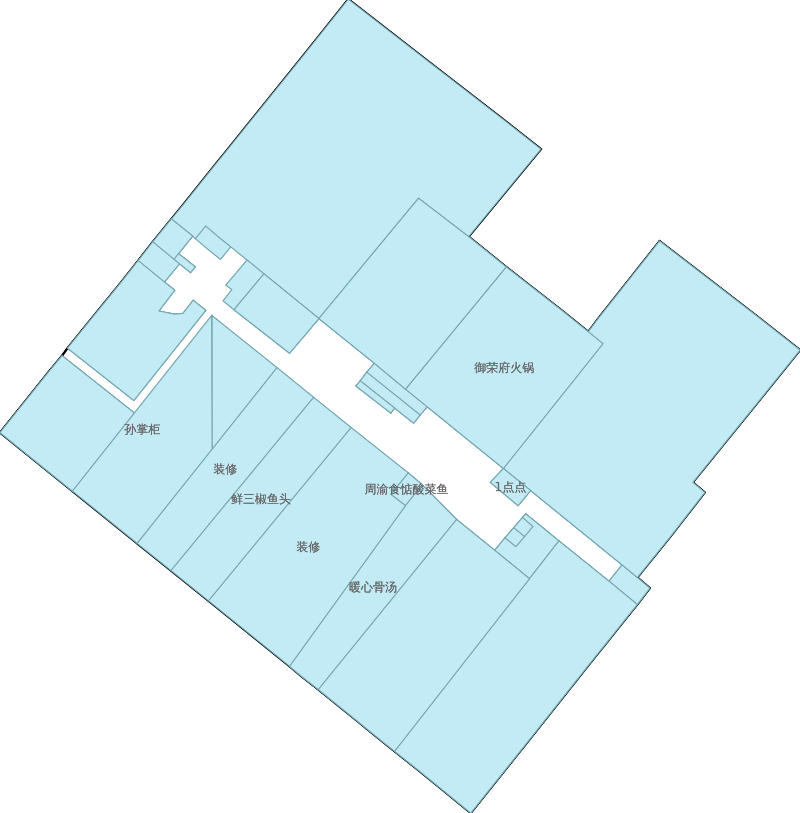

In [10]:
# select one site
sample = list(SUBMISSION_SITES)[0]
data = {}
for path in train_paths:
    path_data = path.split("/")    
    if path_data[2] == sample:
        if not path_data[3] in data.keys():
            data[f"{path_data[3]}"] = []
        data[f"{path_data[3]}"].append(path)

# result has structure devided by its floor
# display(data)


base = ".."
floor = "F2" # because we didnt create matching function of string floor name to the corresponding value;)
site = sample
pathway_paths = data[floor]


floor_plan_filename = f'{base}/metadata/{site}/{floor}/floor_image.png'

sample_pathway = concatenate_formatting_waypoints(pathway_paths)


# Prepare width_meter & height_meter
json_plan_filename = f'{base}/metadata/{site}/{floor}/floor_info.json'
with open(json_plan_filename) as json_file:
    json_data = json.load(json_file)
    
width_meter = json_data["map_info"]["width"]
height_meter = json_data["map_info"]["height"]
title = site

visualize_trajectory(trajectory = sample_pathway,
                     floor_plan_filename = floor_plan_filename,
                     width_meter = width_meter,
                     height_meter = height_meter,
                     title = title
                    )



100%|██████████| 20/20 [00:01<00:00, 13.43it/s]



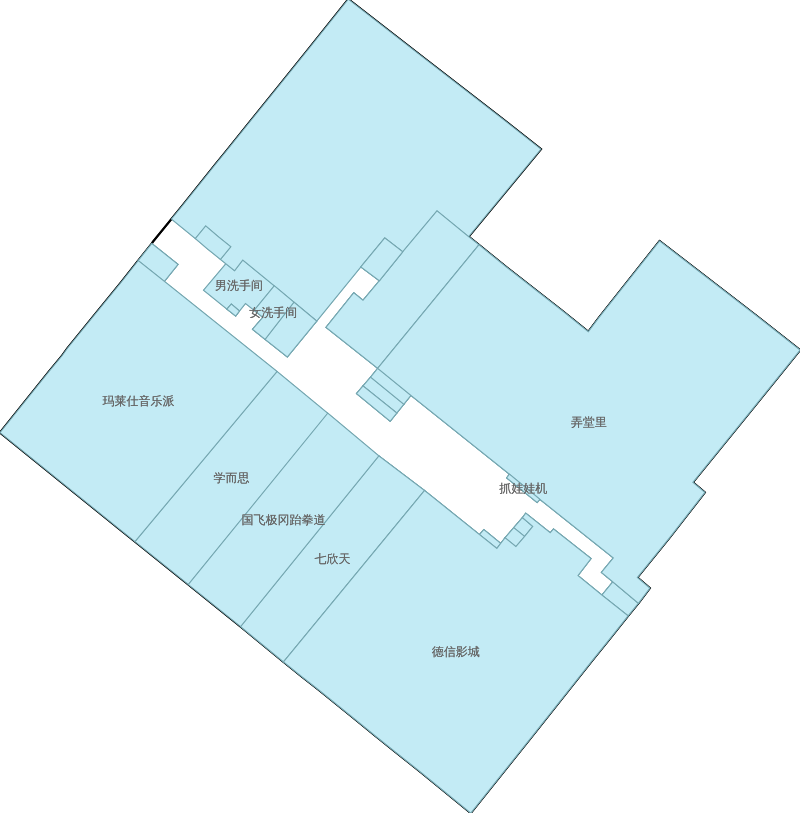

In [11]:
# select one site
sample = list(SUBMISSION_SITES)[0]
data = {}
for path in train_paths:
    path_data = path.split("/")    
    if path_data[2] == sample:
        if not path_data[3] in data.keys():
            data[f"{path_data[3]}"] = []
        data[f"{path_data[3]}"].append(path)

# result has structure devided by its floor
# display(data)


base = ".."
floor = "F3" # because we didnt create matching function of string floor name to the corresponding value;)
site = sample
pathway_paths = data[floor]


floor_plan_filename = f'{base}/metadata/{site}/{floor}/floor_image.png'

sample_pathway = concatenate_formatting_waypoints(pathway_paths)


# Prepare width_meter & height_meter
json_plan_filename = f'{base}/metadata/{site}/{floor}/floor_info.json'
with open(json_plan_filename) as json_file:
    json_data = json.load(json_file)
    
width_meter = json_data["map_info"]["width"]
height_meter = json_data["map_info"]["height"]
title = site

visualize_trajectory(trajectory = sample_pathway,
                     floor_plan_filename = floor_plan_filename,
                     width_meter = width_meter,
                     height_meter = height_meter,
                     title = title
                    )



# 上の画像のパス上で出てくるワイファイのbssidとtestデータで出てくるBSsidを比較する

これは困難なのでパス。floorが特定されていないとできない。

In [ ]:
import itertools

In [ ]:
wifi_sample = []
for path in pathway_paths:
    tmp = read_data_file(path)
    wifi_sample.append(np.array(tmp.wifi)[:,2].tolist())
train_wifis = set(list(itertools.chain.from_iterable(np.array(wifi_sample, dtype=np.ndarray).tolist())))